<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Exploratory Data Analysis on a Natural Language Processing Task
> Authors: Caroline Schmitt, Matt Brems

---

Exploratory data analysis (EDA) is a crucial part of any data science project. EDA helps us discover interesting relationships in the data, detect outliers and errors, examine our own assumptions about the data, and prepare for modeling. During EDA we might discover that we need to clean our data more conscientiously, or that we have more missing data than we realized, or that there aren't many patterns in the data (indicating that modeling may be challenging.)

In this lab you'll bring in a natural language dataset and perform EDA. The dataset contains Facebook statuses taken from between 2009 and 2011 as well as personality test results associated with the users whose Facebook statuses are included.

This dataset uses results from the Big Five Personality Test, also referred to as the five-factor model, which measures a person's score on five dimensions of personality:
- **O**penness : People who are high in this personality trait also tend to be more adventurous and creative.
- **C**onscientiousness : Someone scoring lower in this primary personality trait is less structured and less organized.
- **E**xtroversion : People who are low in this personality trait or introverted tend to be more reserved
- **A**greeableness : People who are high in agreeableness tend to be more cooperative while those low in this personality trait tend to be more competitive and sometimes even manipulative.
- **N**euroticism : Those low in this personality trait tend to be more stable and emotionally resilient.

Notoriously, the political consulting group Cambridge Analytica claims to have predicted the personalities of Facebook users by using those users' data, with the goal of targeting them with political ads that would be particularly persuasive given their personality type. Cambridge Analytica claims to have considered 32 unique 'groups' in the following fashion:
- For each of the five OCEAN qualities, a user is categorized as either 'yes' or 'no'.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$).

Cambridge Analytica's methodology was then, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big Five personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

In this lab you will perform EDA to examine many relationships in the data.

Exploratory data analysis can be a non-linear process, and you're encouraged to explore questions that occur to you as you work through the notebook.

> **Content note**: This dataset contains real Facebook statuses scraped from 2009 to 2011, and some of the statuses contain language that is not safe for work, crude, or offensive. The full dataset is available as `mypersonality.csv`, and a sanitized version containing only statuses that passed an automated profanity check is available as `mypersonality_noprofanity.csv`. Please do not hesitate to use `mypersonality_noprofanity.csv` if you would prefer to. Please note that the automated profanity check is not foolproof. If you have any concerns about working with this dataset, please get in touch with your instructional team.

---

### External resources

These resources are not required reading but may be of use or interest.

- [Python Graph Gallery](https://python-graph-gallery.com/)
- [Wikipedia page](https://en.wikipedia.org/wiki/Big_Five_personality_traits) on the Big Five test
- [A short (3-4 pages) academic paper](./celli-al_wcpr13.pdf) using the `MyPersonality` dataset to model personality

---

## Load packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer

# This setting widens how many characters pandas will display 
# in a column:
pd.options.display.max_colwidth = 400

---

## Load data

In [2]:
df = pd.read_csv('data/mypersonality.csv')

# NOTICE! Do read the commented out code below...
# df = pd.read_csv('data/mypersonality_noprofanity.csv') 
# comment out above & 
# uncomment this to use mypersonality_noprofanity.csv if it 
# makes you more comfortable

df.drop(columns=['NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS', 
                 'DENSITY', 'BROKERAGE', 'NBROKERAGE', 
                 'TRANSITIVITY'], inplace=True)
df.head(3)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM


---

## EDA on Statuses

Before we even vectorize the text, we might look at the lengths and word counts in each Facebook status.

**Create a new column called `status_length` that contains the length of each status:**

In [3]:
df['status_length'] = df['STATUS'].apply(lambda x : len(x))

In [4]:
df.head(3)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,121


**Create a new column called `status_word_count` that contains the number of words in each status:**

Note: You can evaluate this based off of how many strings are separated by whitespaces; you're not required to check that each set of characters set apart by whitespaces is a word in the dictionary.

In [5]:
df['status_word_count'] = df['STATUS'].apply(lambda x : len(x.split(' ')))

In [6]:
df.head(3)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27,5
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63,13
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,121,26


### Longest and shortest statuses

Looking at individual observations can help us get a sense of what the dataset contains.

**Show the five longest and five shortest statuses based off of `status_word_count`:**

In [7]:
df[['STATUS','status_word_count']].sort_values(by='status_word_count')

,STATUS,status_word_count
8316,*PROPNAME*'s?,1
7614,http:////ca.news.yahoo.com//s//capress//091008//world//eu_nobel_literature,1
9099,no,1
229,MLIG!!!,1
4014,2010,1
...,...,...
6989,"If I wear makeup, I'm fake. If I like to get dressed up, I'm a Tart. If I say what i think, I'm a bitch. If I cry sometimes, I'm a drama queen. If I have guy friends, I'm a slut. If I stand up for myself, I'm mouthy. Seems like you can't do anything now a days without being labeled.. So what, go ahead and label me, see if i give a shit. Repost this if your proud of who you are! x x",85
2399,And you run and you run to catch up with the sun but it's sinking. Racing around to come up behind you again. The sun is the same in a relative way but you're older. Shorter of breath and one day closer to death.,86
5680,"I always make it a rule to let the other fellow fire first. If a man wants to fight, I argue the question with him and try to show him how foolish it would be. If he can't be dissuaded, why then the fun begins but I always let him have first crack. Then when I fire, you see, I have the verdict of self-defence on my side. I know that he is pretty certain in his hurry, to miss. I never do.",88
496,"Exact words when renewing DL: Me: Oh no, you can't take my license, It's my 25th b-day. How am I going to get into the bar? DMV: We gonna give you a new one over there Me: But, it won't have my picture and stuff on it. Dmv: Hold up, we can take a picture of your picture and put it on a license i think. (yelling at co-worker to see if this can be done) Yup! Me: So, I can go to the bar?! Dmv: ...",91


## What's the distribution of post lengths?

Use visuals to show the distributions of post lengths. Show both the distribution of word counts and the distribution of lengths based off character.

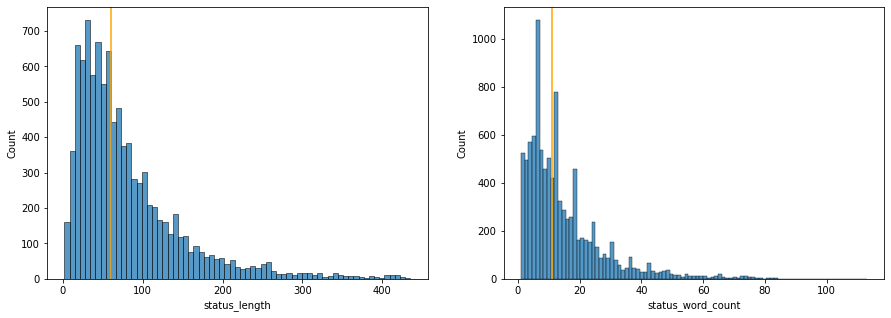

In [8]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

sns.histplot(df['status_length'],ax=ax[0])
ax[0].axvline(df['status_length'].median(),color='orange')
sns.histplot(df['status_word_count'],ax=ax[1])
ax[1].axvline(df['status_word_count'].median(),color='orange')


In [9]:
# Most of people usually type the words around 11 words, which contain 60 characters.

---

## EDA of Personality Scores

There are two sets of personality columns in the dataset: class and score. According to the attached paper, scores have been converted to categories based on whether a score for a user fell above or below the median.

### Plot the distributions of personality scores for all five score columns:

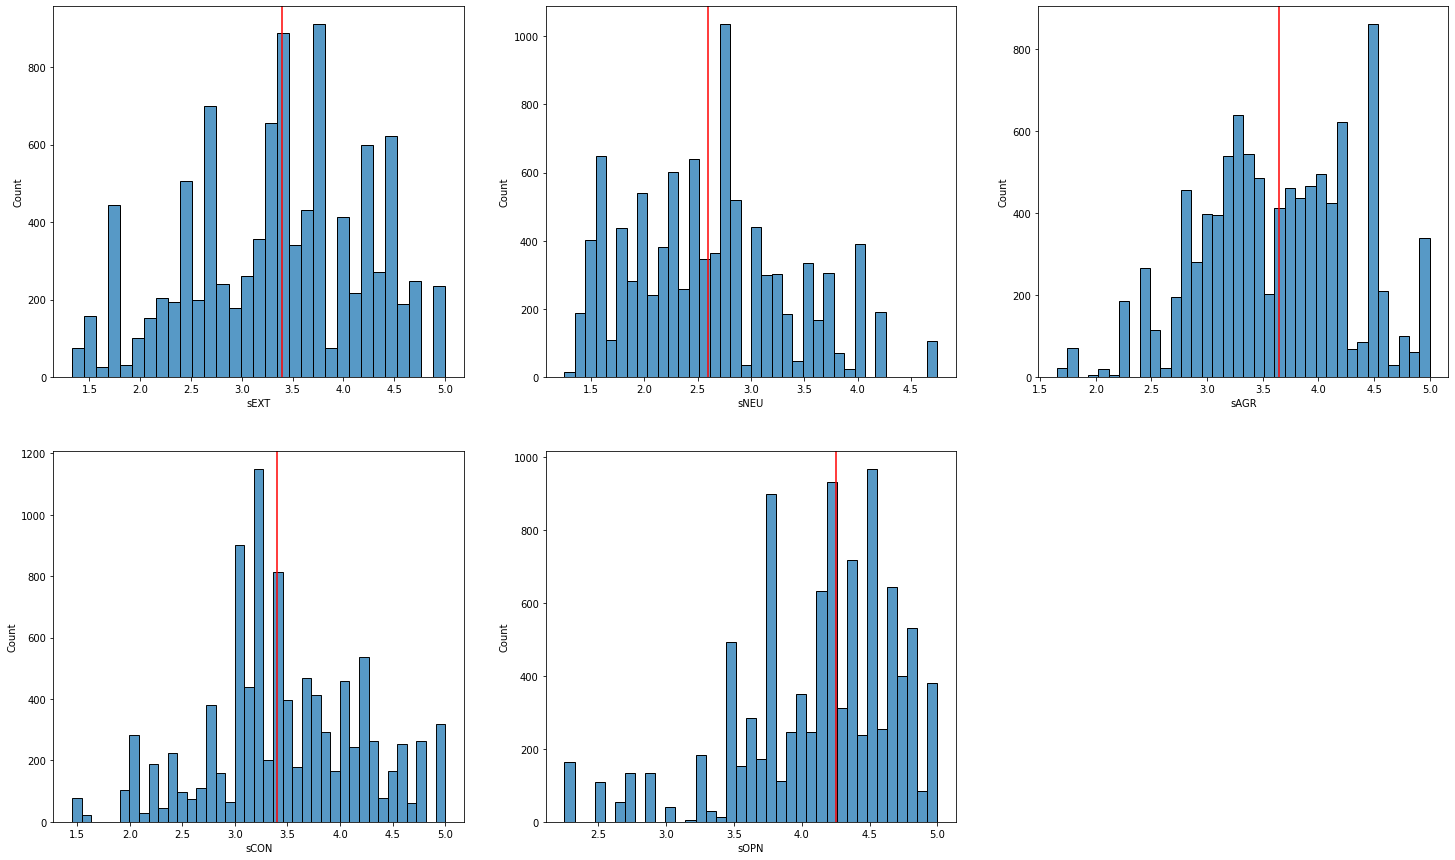

In [10]:
fig,ax = plt.subplots(2,3,figsize=(25,15))
fig.delaxes(ax[1,2])
sns.histplot(df['sEXT'],ax=ax[0][0])
ax[0][0].axvline(df['sEXT'].median(),color='red')

sns.histplot(df['sNEU'],ax=ax[0][1])
ax[0][1].axvline(df['sNEU'].median(),color='red')

sns.histplot(df['sAGR'],ax=ax[0][2])
ax[0][2].axvline(df['sAGR'].median(),color='red')

sns.histplot(df['sCON'],ax=ax[1][0])
ax[1][0].axvline(df['sCON'].median(),color='red')

sns.histplot(df['sOPN'],ax=ax[1][1])
ax[1][1].axvline(df['sOPN'].median(),color='red')



---

### How many unique users exist in the dataset?

This dataset has redacted original poster names, but each user is given an `#AUTHID`. How many unique users are there, and how many posts per user do we have?

In [ ]:
df.groupby('#AUTHID')['STATUS'].count()

In [ ]:
sns.histplot(df.groupby('#AUTHID')['STATUS'].count(),bins=80)
plt.axvline(df.groupby('#AUTHID')['STATUS'].count().median(),color='red')

In [ ]:
# From the average, the user tend to write only 25 statuses per user

## EDA on unique users

Because we have many posts per user for most users, doing EDA on the personality score columns might be misleading. If we have 200 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `'y'` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

**Create a new dataframe called `unique_users` that only contains the `#AUTHID`, personality score, and personality category columns:**

If you do this correctly, it should have 250 rows and 11 columns.

(Hint: You can use the pandas [drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

In [128]:
# #AUTHID, personality score, and personality category columns:
unique_users = pd.DataFrame(df[['#AUTHID','sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN']])

In [129]:
unique_users.drop_duplicates(inplace =True)

In [130]:
unique_users

,#AUTHID,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN
0,b7b7764cfa1c523e4e93ab2a79a946c4,2.65,3.00,3.15,3.25,4.40,n,y,n,n,y
102,318bf822d4f2bd3920367560218619c0,4.50,4.00,3.00,4.50,3.75,y,y,n,y,n
171,ecbddbfe00e0f83cfdb802a7186061c7,4.30,2.15,3.60,3.30,4.10,y,n,y,n,y
236,db39f7b2aad360b1033ec1f8fcd57f9c,4.65,3.20,3.05,3.65,4.75,y,y,n,y,y
246,4d035bd3fd8d9595d15cea9e388964be,3.70,2.90,3.40,3.35,4.05,y,y,n,n,y
...,...,...,...,...,...,...,...,...,...,...,...
9909,a764ca41dca158d7a191505dcc8ce47f,3.70,2.50,4.20,4.10,3.60,y,n,y,y,n
9910,deb899e426c1a5c66c24eeb0d7df6257,2.15,2.15,4.10,2.90,4.60,n,n,y,n,y
9912,ea28a927cb6663480ea33ca917c3c8ba,4.05,3.35,3.80,3.95,4.50,y,y,y,y,y
9914,5532642937eb3497a43e15dbb23a9d2d,1.40,4.05,3.30,3.40,3.95,n,y,n,n,y


In [120]:
unique_users.shape

(250, 11)

**Plot the distribution of personality scores for `unique_users`:**

Do the distributions look different? Here, each individual user will only be represented once.

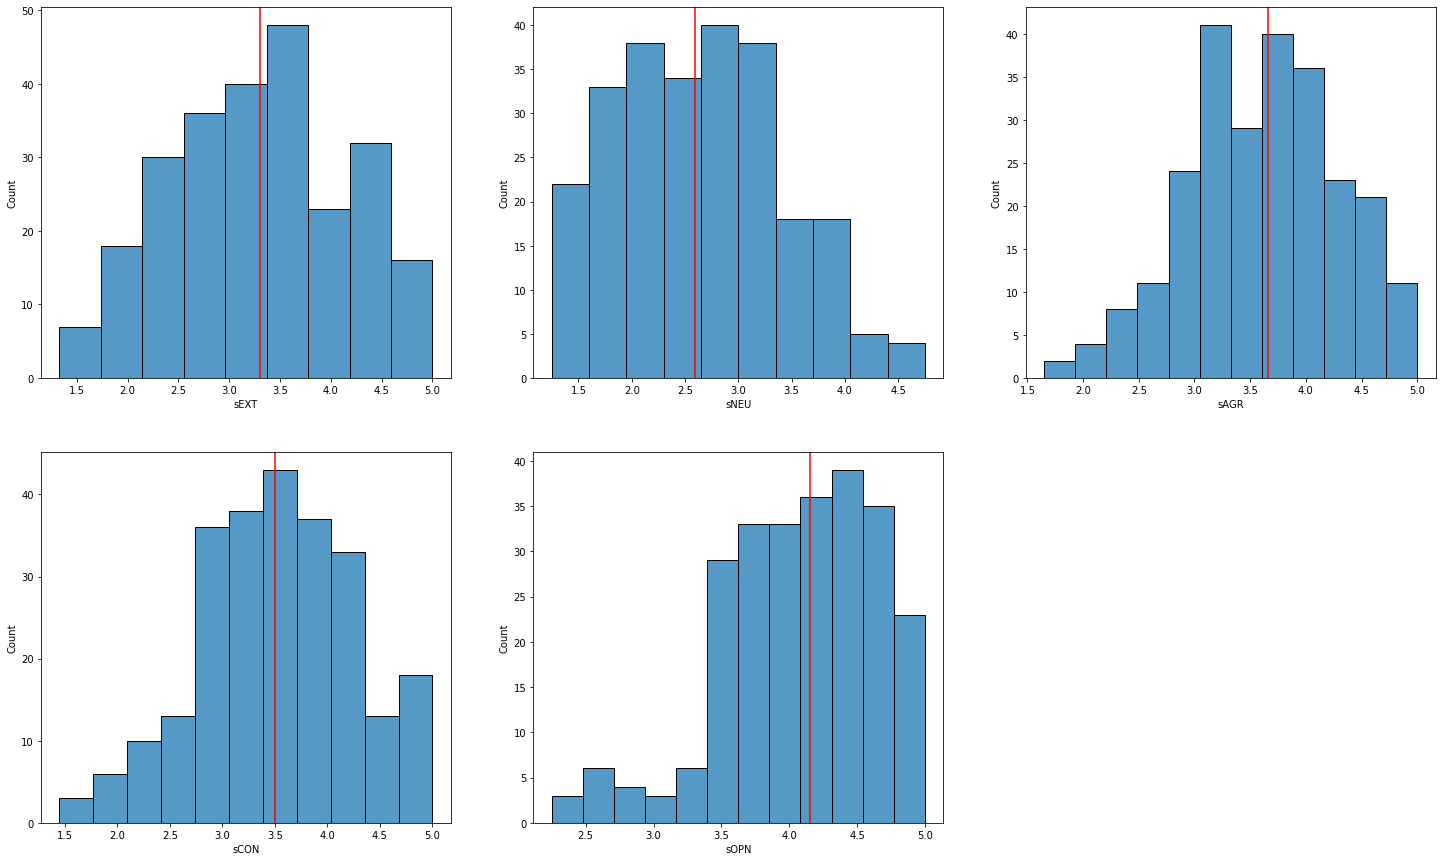

In [276]:
fig,ax = plt.subplots(2,3,figsize=(25,15))

fig.delaxes(ax[1,2])

sns.histplot(unique_users['sEXT'],ax=ax[0][0])
ax[0][0].axvline(unique_users['sEXT'].median(),color='red')

sns.histplot(unique_users['sNEU'],ax=ax[0][1])
ax[0][1].axvline(unique_users['sNEU'].median(),color='red')

sns.histplot(unique_users['sAGR'],ax=ax[0][2])
ax[0][2].axvline(unique_users['sAGR'].median(),color='red')

sns.histplot(unique_users['sCON'],ax=ax[1][0])
ax[1][0].axvline(unique_users['sCON'].median(),color='red')

sns.histplot(unique_users['sOPN'],ax=ax[1][1])
ax[1][1].axvline(unique_users['sOPN'].median(),color='red')



**Use the `.describe()` method on `unique_users`:**

In [277]:
unique_users.describe()

,sEXT,sNEU,sAGR,sCON,sOPN,Count_status
count,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000
mean,3.292120,2.627240,3.600320,3.522920,4.07856,39.664000
std,0.861368,0.776835,0.670758,0.740211,0.57506,43.555152
min,1.330000,1.250000,1.650000,1.450000,2.25000,1.000000
25%,2.662500,2.000000,3.150000,3.000000,3.75000,8.000000
50%,3.300000,2.590000,3.660000,3.500000,4.15000,25.000000
75%,4.000000,3.150000,4.100000,4.050000,4.50000,54.750000
max,5.000000,4.750000,5.000000,5.000000,5.00000,223.000000


### Plots vs. Tables

Consider what different information is easily conveyed by the plots of scores, versus the table with summary statistics. Explain when you might present a distribution versus when you might present a table of summary statistics.

- From plots
    - The average of the values can be easily seen
    - The distribution of values can be easily seen, which one the most or the lowest.
    
    
- From table
    - When want to find the outlier values
    - When want to compare the mean value that are slightly different. 
    - Statitic table can show std, quartiles, and total number of data easily.


#### Other visualizations:

Create 1-2 additional visualizations related to the `unique_users` dataframe.

You might consider:
- Bar charts of users per category per trait
- Seaborn correlation heatmap
- Seaborn pairplot

In [278]:
unique_users.columns

Index(['#AUTHID', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT', 'cNEU',
       'cAGR', 'cCON', 'cOPN', 'Count_status'],
      dtype='object')

<AxesSubplot: >

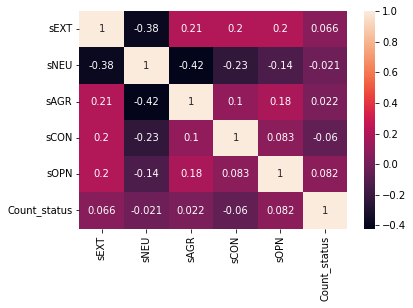

In [280]:
sns.heatmap(unique_users.corr(),annot=True)
# The AGR and NEU score are highest correlated

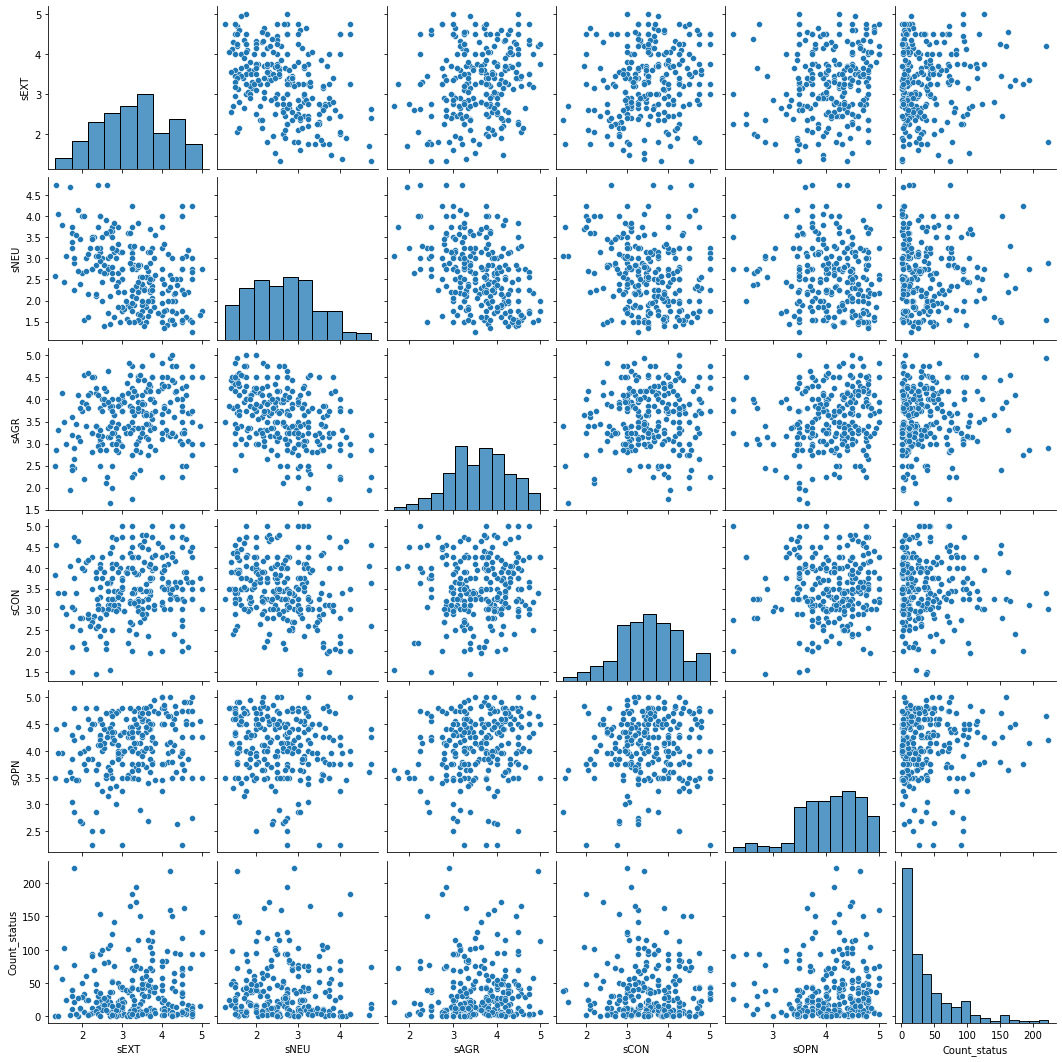

In [282]:
sns.pairplot(unique_users)

<AxesSubplot: ylabel='cCON'>

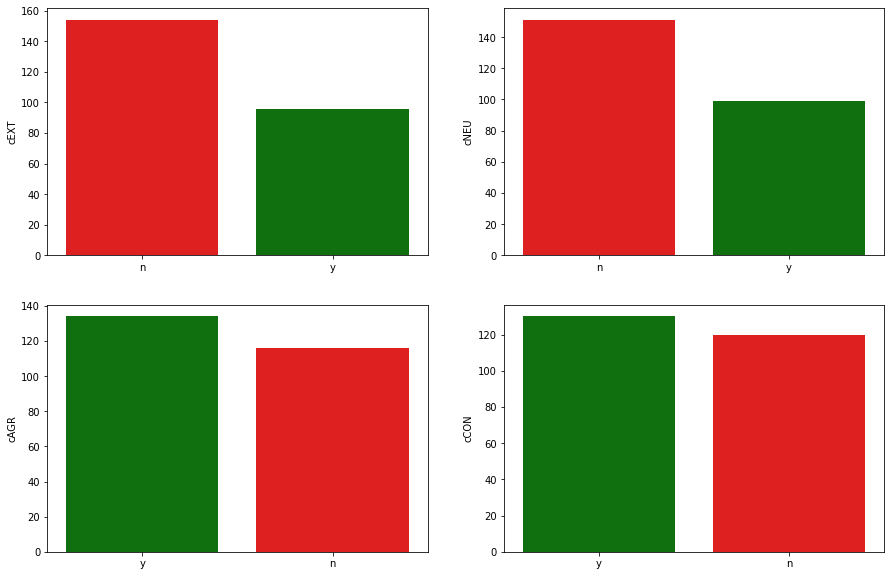

In [283]:

fig,ax = plt.subplots(2,2,figsize=(15,10))
sns.barplot(x=unique_users['cEXT'].value_counts().index,y = unique_users['cEXT'].value_counts(),palette = ['red','green'],ax=ax[0][0])
sns.barplot(x=unique_users['cNEU'].value_counts().index,y = unique_users['cNEU'].value_counts(),palette = ['red','green'],ax=ax[0][1])
sns.barplot(x=unique_users['cAGR'].value_counts().index,y = unique_users['cAGR'].value_counts(),palette = ['green','red'],ax=ax[1][0])
sns.barplot(x=unique_users['cCON'].value_counts().index,y = unique_users['cCON'].value_counts(),palette = ['green','red'],ax=ax[1][1])
# There are different in the number of personality trait that post the Facebook status.

---

## Exploring status length and word count based on personality

**Using `groupby()`, find the mean status length and status word count for posts by users in the high and low categories of each of the Big 5 traits.**

You'll need to use `groupby()` five separate times for this.

In [104]:
df.groupby('cEXT')[['status_length','status_word_count']].mean()

,status_length,status_word_count
cEXT,,
n,79.866655,14.659891
y,81.704918,14.843906


In [105]:
df.groupby('cNEU')[['status_length','status_word_count']].mean()

,status_length,status_word_count
cNEU,,
n,80.852396,14.753025
y,80.304278,14.712941


In [106]:
df.groupby('cAGR')[['status_length','status_word_count']].mean()

,status_length,status_word_count
cAGR,,
n,80.976769,14.857389
y,80.355800,14.632618


In [107]:
df.groupby('cCON')[['status_length','status_word_count']].mean()

,status_length,status_word_count
cCON,,
n,81.920149,14.969963
y,79.149034,14.465101


In [108]:
df.groupby('cOPN')[['status_length','status_word_count']].mean()

,status_length,status_word_count
cOPN,,
n,85.686298,15.653318
y,78.905143,14.421631


**Choose one of the personality category columns (i.e. `cOPN`, `cCON`, `cEXT`, `cAGR`, or `cNEU`.) Use `sns.distplot()` to visualize the distribution of status word counts for posts by users who score both high (`y`) and low (`n`) in that personality category:**

In [285]:
df['cOPN'].value_counts()

y    7369
n    2547
Name: cOPN, dtype: int64

In [286]:
y_OPN = df[df['cOPN'] == 'y']
n_OPN = df[df['cOPN'] == 'n']

In [287]:
print(y_OPN.shape)
print(n_OPN.shape)

(7369, 18)
(2547, 18)


<AxesSubplot: xlabel='status_word_count', ylabel='Density'>

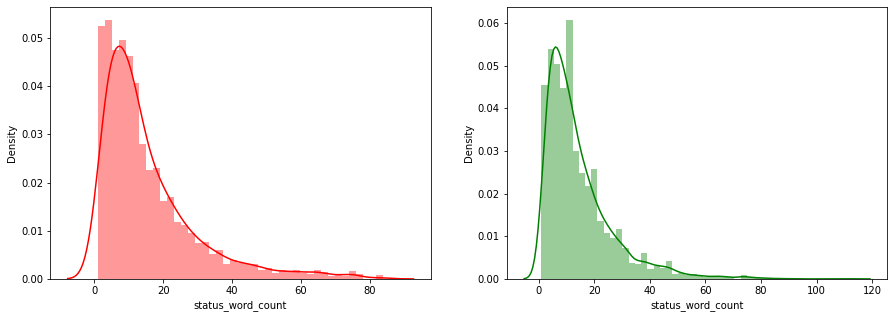

In [288]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.distplot(n_OPN['status_word_count'],ax=ax[0],color='red');
sns.distplot(y_OPN['status_word_count'],ax=ax[1],color='green')


---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count-vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.

In [379]:
X = df['STATUS']

In [380]:
cvec = CountVectorizer()
X_cvec = cvec.fit_transform(X)
vec = pd.DataFrame(X_cvec.toarray(),columns= cvec.get_feature_names_out())

In [381]:
vec

,00,000,000ft,00am,00pm,01,02,02pm,03,0330,...,équipe,étais,était,étant,état,été,être,østersund,últimas,últimos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9911,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9912,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9914,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Show the 15 most common words

In [382]:
vec.sum().sort_values(ascending = False).head(15)

the         4982
to          4476
is          3156
and         3057
of          2093
in          1984
it          1669
for         1641
my          1564
you         1495
propname    1309
that        1158
on          1094
with         956
be           894
dtype: int64

### Show the 15 frequency of the most common words as a bar chart

**Hint**: You can do this in one line of code. [This webpage](https://dfrieds.com/data-visualizations/bar-plot-python-pandas.html) has an example.

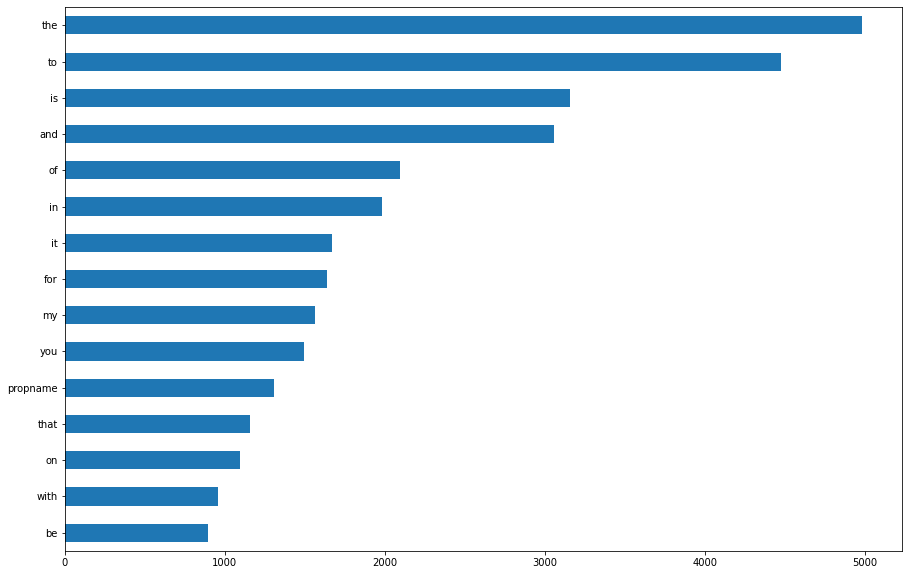

In [383]:
plt.figure(figsize=(15,10))

vec.sum().sort_values(ascending = False).head(15)[::-1].plot(kind='barh');

### Investigating `propname`

The word `propname` shows up frequently in this dataset. Show the first 10 statuses in the dataset that contain `propname`:

In [384]:
status_vec = pd.concat([df['STATUS'],vec],axis=1)

In [385]:
status_vec[status_vec['propname'] >=1][['STATUS']].head(10)

,STATUS
6,"saw a nun zombie, and liked it. Also, *PROPNAME* + Tentacle!Man + Psychic Powers = GREAT Party."
18,"is tired. *PROPNAME*, let me go to sleep pl0x."
69,has a fair idea of how to manage the 2.5 kids cliche... She just needs a very strong gentleman named *PROPNAME* and thriteen wet napkins.
101,has a serious crush on *PROPNAME*. <3
104,Mondays are the new thursdays- anthony bourdain + *PROPNAME* = forgetting your financial troubles
118,is *PROPNAME*'s bestbian
139,is in love with *PROPNAME*.
158,is in love. With *PROPNAME*.
170,Ten Movies to Watch Right Now (and some you can Instant Netflix) 1. La Vie En Rose 2. Shrink (if you love LA) 3. Paris Je'taime (if you love Paris) 3. Clay Pidgeons (*PROPNAME* is priceless) 4. Quills 5. Away We Go 6. Sunshine Cleaning 7. A League of Their Own 8. Smart People (I Heart *PROPNAME*'s Page and SJP) 9. Frost//Nixon 10. Doubt
202,"ATTENTION EVERYONE!!! Vote for the short ""AFTER HOURS"" to support *PROPNAME* - our local Michigan talent and a wonderful person. Repost please!!! http:////www.thirteen.org//sites//reel13//category//vote//"


**Provide a short explanation of what you believe `propname` to be:**

In [ ]:
# Placeholder for the word that lead to thirdperson name.

## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality scores from the original dataframe.

**Create a new dataframe called `text_and_scores` that concatenates the count-vectorized statuses side-by-side with the original personality category columns:**

In [ ]:
df.columns

In [ ]:
text_and_score = pd.concat([vec,df[['cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']]],axis=1)

**Show the 25 most common words for statuses from high-cAGR users:**

In [ ]:
high_cAGR = text_and_score[text_and_score['cAGR'] == 'y']
high_cAGR.drop(columns=['cEXT', 'cNEU','cAGR', 'cCON', 'cOPN'],inplace=True)

high_cAGR.sum().sort_values(ascending = False).head(25)

**Show the 25 most common words for statuses from low-cAGR users:**

In [ ]:
low_cAGR = text_and_score[text_and_score['cAGR'] == 'n']
low_cAGR.drop(columns=['cEXT', 'cNEU','cAGR', 'cCON', 'cOPN'],inplace=True)

low_cAGR.sum().sort_values(ascending = False).head(25)

### (BONUS) Most common bigrams:

This is a bonus section and not required (**_though highly recommended_**).

Find the 10 most common [bigrams](https://en.wikipedia.org/wiki/Bigram) in the dataset.

In [47]:
bi_cvec = CountVectorizer(ngram_range=(2,2))
X_bi_cvec = bi_cvec.fit_transform(X)
bi_vec = pd.DataFrame(X_bi_cvec.toarray(),columns= bi_cvec.get_feature_names_out())

In [48]:
bi_vec.shape

(9916, 75427)

In [51]:
bi_vec.sum().sort_values(ascending=False)[:10]

in the      448
of the      323
for the     318
going to    295
to the      290
to be       284
on the      217
at the      172
to get      165
to go       162
dtype: int64

### (BONUS) Most common trigrams:

This is a bonus section and not required (**_though highly recommended_**).

Find the 10 most common [trigrams](https://en.wikipedia.org/wiki/Trigram) in the dataset.

In [52]:
tri_cvec = CountVectorizer(ngram_range=(3,3))
X_tri_cvec = tri_cvec.fit_transform(X)
tri_vec = pd.DataFrame(X_tri_cvec.toarray(),columns= tri_cvec.get_feature_names_out())

In [53]:
tri_vec.shape

(9916, 104662)

In [54]:
tri_vec.sum().sort_values(ascending=False)[:10]

is going to                   93
propname and propname         56
going to be                   45
looking forward to            41
to go to                      38
going to the                  35
propname propname propname    34
out of the                    32
in the morning                29
the rest of                   28
dtype: int64

---

## Choose your own adventure

By now you've looked at a lot of visualizations and frequency counts.

Come up with 2-3 questions about the data, and try to answer them using descriptive statistics (like counts, averages, etc.) or visualizations.

Some questions you might explore:
- Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset?
- `PROPNAME` has been used to redact personal names. Given that this data was scraped between 2009 and 2011, investigate if any public figures or famous people show up in the dataset, or their names have been redacted as well.
- Is count of uppercase letters vs. lowercase letters per status related to any personality category or personality score?
- Is _average_ word count per status related to any personality category or personality metric?
- Is punctuation use related to personality?

Or, of course, come up with your own questions to investigate!

The focus here is on "explore" -- you might not find anything of particular interest, but don't let that discourage you.

In [87]:
# Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset
df['number'] = df['STATUS'].str.findall(pat='[0-9]{5,5}')

In [102]:
df['number'].value_counts()[:5]

[]         9870
[24676]      23
[15000]       2
[20307]       2
[24797]       2
Name: number, dtype: int64

In [160]:
# Is average word count per status related to any personality category or personality metric?

# create dictionary to count the frequency of status per users
count_sta = {}
for i in df['#AUTHID']:
    if i not in count_sta:
        count_sta[i] = 1
    else:
        count_sta[i] +=1
        
# obtain only frequency of status into list and assign it to unique_df with the same order.
unique_users['Count_status'] = list(value for key,value in count_sta.items())

{'b7b7764cfa1c523e4e93ab2a79a946c4': 102,
 '318bf822d4f2bd3920367560218619c0': 69,
 'ecbddbfe00e0f83cfdb802a7186061c7': 65,
 'db39f7b2aad360b1033ec1f8fcd57f9c': 10,
 '4d035bd3fd8d9595d15cea9e388964be': 40,
 '172400f46880b309ca5e97d322bb8f01': 73,
 '200255966ca6e2636535b5b93ac04497': 37,
 '5489ed38556af050d6a93e5d27b95dfb': 10,
 'b9a44bb356832160caccc9eb3614e0ce': 43,
 '9a8cf1dcb2de1a8f70c4745a636bbb96': 70,
 '527ed53d2ba3a3bc417b8402d5b2f556': 194,
 '751e53fc64b770f7b5ea2b0964678599': 56,
 'c19a4fb5e846fb6575b0a8f3a2081ea0': 72,
 'e6cdef6f475cce3023c5b715f8c9f110': 223,
 '2badb47503a98766c89e266d1130969a': 43,
 '1c10cc0852579d2fa000e3fc3327bb98': 20,
 '0737e4e4980f56c9fb1cb5743001c917': 172,
 'a6336ec5e11839ae33aee01fa2163652': 74,
 '3d7847b1c33b5f5811208b4aa1a7ffbd': 101,
 '83aeafc166238ebf5aaa2530e6205341': 25,
 '2ea1efd66ffc011621a4a74e06005e23': 83,
 '9b73d5a07c079cce614932e39e2f1852': 82,
 'd298a6d98000dc07bbb7994f71d867d3': 53,
 '450c787001b004af69428e267c7a4ca1': 69,
 'd7f1da355

In [179]:
unique_users.columns

Index(['#AUTHID', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT', 'cNEU',
       'cAGR', 'cCON', 'cOPN', 'Count_status'],
      dtype='object')

In [192]:
# create dataframe that contain the average of frequent status in each category of personality type
count_status_personal = pd.DataFrame([unique_users.groupby(['cEXT'])['Count_status'].mean(),unique_users.groupby(['cNEU'])['Count_status'].mean(),\
             unique_users.groupby(['cAGR'])['Count_status'].mean(),unique_users.groupby(['cCON'])['Count_status'].mean(),\
             unique_users.groupby(['cOPN'])['Count_status'].mean()],index=['EXT','NEU','AGR','CON','OPN'])

In [193]:
count_status_personal

,n,y
EXT,37.058442,43.843750
NEU,41.052980,37.545455
AGR,40.077586,39.305970
CON,44.666667,35.046154
OPN,34.418919,41.869318


Text(0, 0.5, 'Average frequency of status')

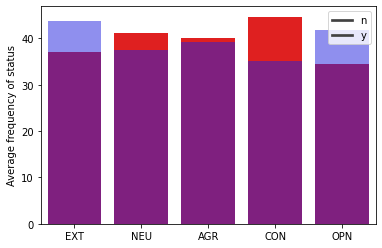

In [220]:
# Plot the frequency of status in each class of personality type
sns.barplot(count_status_personal.index,count_status_personal['n'],color='red')
sns.barplot(count_status_personal.index,count_status_personal['y'],color='blue',alpha=0.5)
plt.legend(labels = ['n','y'],)
plt.ylabel('Average frequency of status')

#### The group of EXT and OPN tend to post frequently more than NEU , AGR and CON 

In [239]:
# Is the 'Punctuation', e.g. ?,! show any related to personality category, score

# Find ! and ? in each status
df['!_or_?'] = df['STATUS'].str.findall(pat='[!?]')

In [262]:
# create new column that contain the count number of founded punctuation

df['Count_punc'] = df['!_or_?'].apply(lambda x: len(x))

In [274]:
# create dataframe that contain the average punctuation used per status in each category of personality type
count_punct_personal = pd.DataFrame([df.groupby('cEXT')['Count_punc'].mean(),df.groupby('cNEU')['Count_punc'].mean(),\
             df.groupby('cAGR')['Count_punc'].mean(),df.groupby('cCON')['Count_punc'].mean(),\
             df.groupby('cOPN')['Count_punc'].mean()],index=['EXT','NEU','AGR','CON','OPN'])
count_punct_personal

,n,y
EXT,0.826704,0.939416
NEU,0.899661,0.832661
AGR,0.773069,0.964116
CON,0.863993,0.886962
OPN,0.843345,0.885330


Text(0, 0.5, 'Average frequency of status')

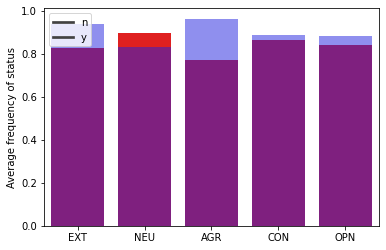

In [275]:
# Plot the frequency of average punctuation used per status in each class of personality type
sns.barplot(count_punct_personal.index,count_punct_personal['n'],color='red')
sns.barplot(count_punct_personal.index,count_punct_personal['y'],color='blue',alpha=0.5)
plt.legend(labels = ['n','y'],)
plt.ylabel('Average frequency of status')

#### Most of personality type frequently use punctuation, except NEU type that prefer to avoid using punctuation.

---

## Exploratory vs. Explanatory Data Analysis 

> **Exploratory analysis** is what you do to get familiar with the data. You may start out with a hypothesis or question, or you may just really be delving into the data to determine what might be interesting about it. Exploratory analysis is the process of turning over 100 rocks to find perhaps 1 or 2 precious gemstones.
>
> **Explanatory analysis** is what happens when you have something specific you want to show an audience - probably about those 1 or 2 precious gemstones. In my blogging and writing, I tend to focus mostly on this latter piece, explanatory analysis, when you've already gone through the exploratory analysis and from this have determined something specific you want to communicate to a given audience: in other words, when you want to tell a story with data.

- Cole Nussbaumer Knaflic, [exploratory vs. explanatory analysis](http://www.storytellingwithdata.com/blog/2014/04/exploratory-vs-explanatory-analysis)

### Choose one visual to explain:

Now that you've performed an exploratory data analysis, choose a visual (or 1-3 related visuals) to frame as **_explanatory_**. This can be a visual you created above, or you can create a new visual. For this visual, make sure the visuals are formatted clearly, and provide a one to two paragraph explanation/interpretation of the visual.

In [358]:
count_class = pd.DataFrame([df['cEXT'].value_counts(),df['cNEU'].value_counts(),\
             df['cAGR'].value_counts(),df['cCON'].value_counts(),\
             df['cOPN'].value_counts()])
count_class.sort_values(by='y',ascending=False,inplace=True)

Text(0, 0.5, 'The number of personality trait\n show in the dataset')

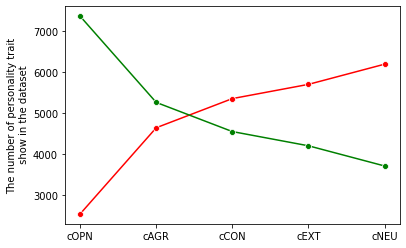

In [378]:
sns.lineplot(y=count_class['n'],x=count_class.index,color='red',marker = "o")
sns.lineplot(y=count_class['y'],x=count_class.index,color='green',marker='o')
plt.ylabel('The number of personality trait\n show in the dataset')

### From the dataset show that group of people who are Openness and Agreeableness tend to appears and interacts more on Facebook, so the data obtained this group of person a lot. On the other hand,  the Concientiousness, Extroversion and Neuroticism tend to not interact much on Facebook. 

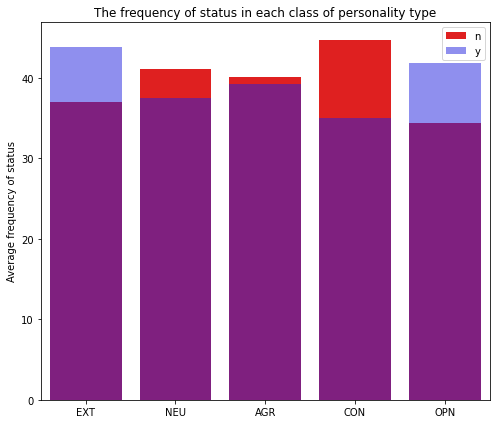

In [323]:
fig,ax = plt.subplots(1,figsize=(7,6))
sns.barplot(count_status_personal.index,count_status_personal['n'],color='red',label='n')
plt.legend()
sns.barplot(count_status_personal.index,count_status_personal['y'],color='blue',alpha=0.5,label='y')
plt.legend()
plt.ylabel('Average frequency of status');
plt.title('The frequency of status in each class of personality type')
plt.tight_layout()

### The frequency of the status posted show that  person who is categorized in personality trait of Extroversion or Openness tend to posts more than the person who is categorized in personality trait of Agreeableness, Neuroticism and Concientiousness